In [1]:
!git clone https://github.com/oops-moment/Remote-Sensing-BTP-1.git
%cd Remote-Sensing-BTP-1/
!pip install pyrsgis
!pip install matplotlib_scalebar

Cloning into 'Remote-Sensing-BTP-1'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 19 (delta 1), reused 15 (delta 0), pack-reused 0
Receiving objects: 100% (19/19), done.
Resolving deltas: 100% (1/1), done.
/content/Remote-Sensing-BTP-1


In [4]:
import subprocess

In [5]:
running_on_colab = True

In [6]:
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

#     import subprocess
#     subprocess.run("pip install pyrsgis", shell=True)
#     subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
! pip install tensorflow

In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
# constants for program

input_bands = [i+1 for i in range(0,7)]
nBands = len(input_bands)
ndvi_band = 9
labels_band = 8

print('Analyzing bands: ', input_bands)
print('nBands: ', nBands)

downsampleMajority = False

diu.setGlobalVariables(input_bands, nBands)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/"
else: image_base_path = "../SatelliteImages/"

loadModel = True

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7



First training image NDVI band:
Saving image:  SavedPlots/BasicNN/krishna_1/NDVI_krishna_1_2001.png


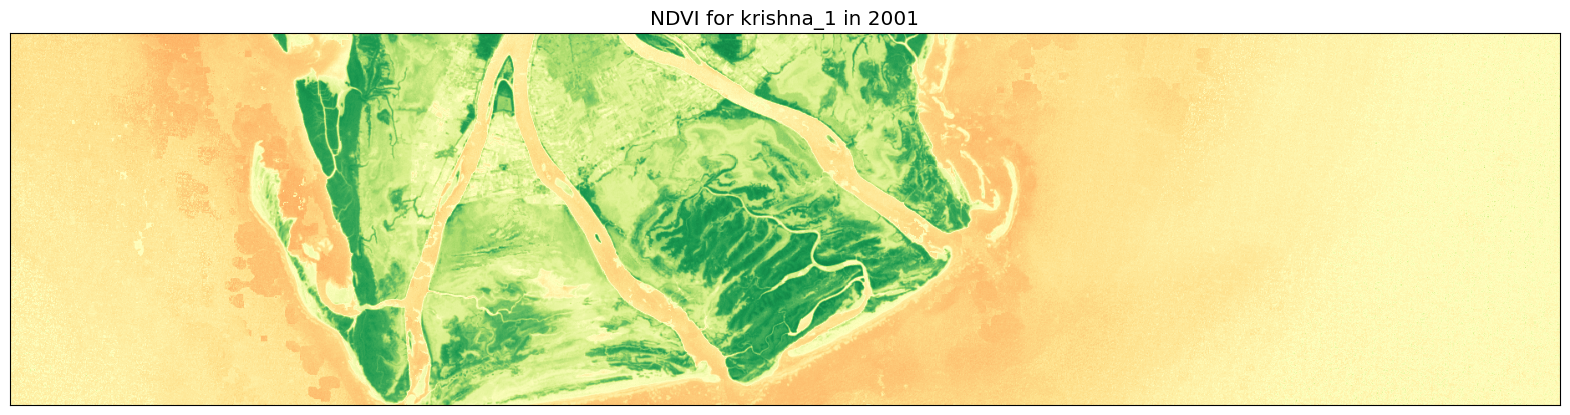


First training image mangroves from labels: 
Saving image:  SavedPlots/BasicNN/krishna_1/LabeledMangroves_krishna_1_2000.png


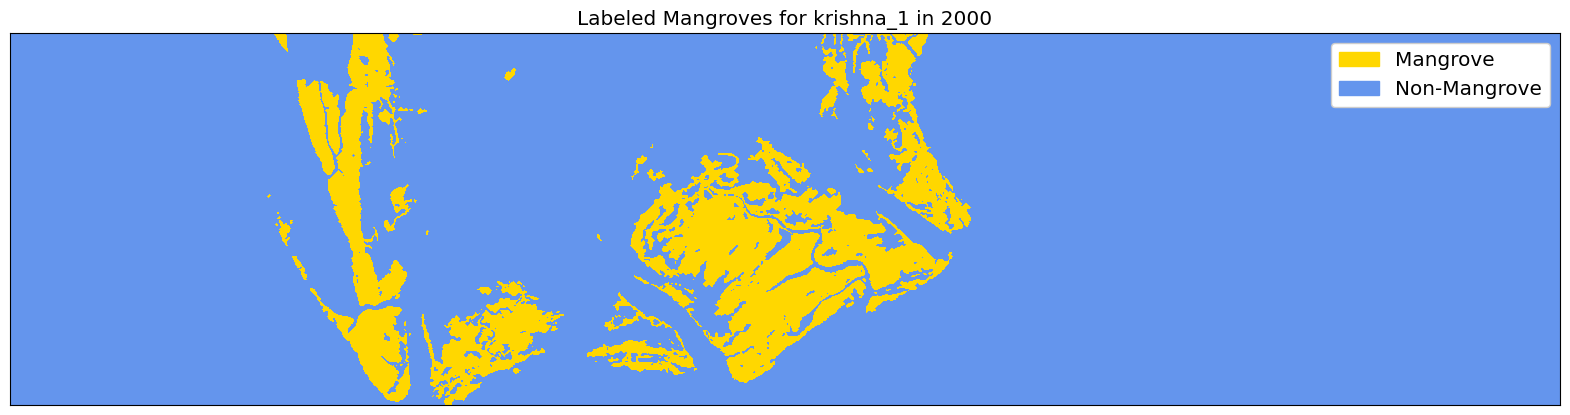

The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
Using training data of length:  825475
Class 0: 735309 Class 1: 90166
Class 0:  89.1% Class 1:  10.9%


In [18]:
# generate training data from chosen images
training_images = []

training_images.append(image_base_path + "krishna_1_2001.tif")
# training_images.append(image_base_path + "Florida_3_2000.tif")
# training_images.append(image_base_path + "Florida_4_2000.tif")
# training_images.append(image_base_path + "Florida_5_2000.tif")
# training_images.append(image_base_path + "Florida_6_2000.tif")
# training_images.append(image_base_path + "Florida_7_2000.tif")

# training_images.append(image_base_path + "Brazil_2_2000.tif")

model_input_data, model_input_labels = diu.loadTrainingImages(training_images, downsampleMajority)

In [25]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, model_input_labels, test_size=0.4, random_state=42, stratify=model_input_labels, shuffle=True)

# reshape it as an additional step for input into the NN
xTrain = xTrain.reshape((xTrain.shape[0], 1, nBands))
xTest = xTest.reshape((xTest.shape[0], 1, nBands))

print(xTrain.shape)
print(xTest.shape)

(495285, 1, 7)
(330190, 1, 7)


In [26]:
model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1, nBands)),
      keras.layers.Dense(14, activation='relu'),
      keras.layers.Dense(14, activation='relu'),
      keras.layers.Dense(2, activation='softmax')])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=10)

print(model.summary())

Epoch 1/10
10835/10835 [==============================] - 47s 4ms/step - loss: 0.5663 - accuracy: 0.9596 - val_loss: 0.0981 - val_accuracy: 0.9679
Epoch 2/10
10835/10835 [==============================] - 43s 4ms/step - loss: 0.0892 - accuracy: 0.9703 - val_loss: 0.0721 - val_accuracy: 0.9753
Epoch 3/10
10835/10835 [==============================] - 46s 4ms/step - loss: 0.0744 - accuracy: 0.9737 - val_loss: 0.0724 - val_accuracy: 0.9753
Epoch 4/10
10835/10835 [==============================] - 43s 4ms/step - loss: 0.0698 - accuracy: 0.9748 - val_loss: 0.0665 - val_accuracy: 0.9762
Epoch 5/10
10835/10835 [==============================] - 43s 4ms/step - loss: 0.0679 - accuracy: 0.9752 - val_loss: 0.0659 - val_accuracy: 0.9764
Epoch 6/10
10835/10835 [==============================] - 42s 4ms/step - loss: 0.0671 - accuracy: 0.9758 - val_loss: 0.0633 - val_accuracy: 0.9771
Epoch 7/10
10835/10835 [==============================] - 41s 4ms/step - loss: 0.0663 - accuracy: 0.9761 - val_loss: 0

In [31]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
device_name = tf.test.gpu_device_name()

In [34]:
print(device_name)

/device:GPU:0


10319/10319 [==============================] - 17s 2ms/step
(330190, 2)
Confusion matrix:
 [[289650   4474]
 [  3226  32840]]

P-Score: 0.880, R-Score: 0.911
Accuracy: 0.977
f1: 0.895
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99    294124
         1.0       0.88      0.91      0.90     36066

    accuracy                           0.98    330190
   macro avg       0.93      0.95      0.94    330190
weighted avg       0.98      0.98      0.98    330190



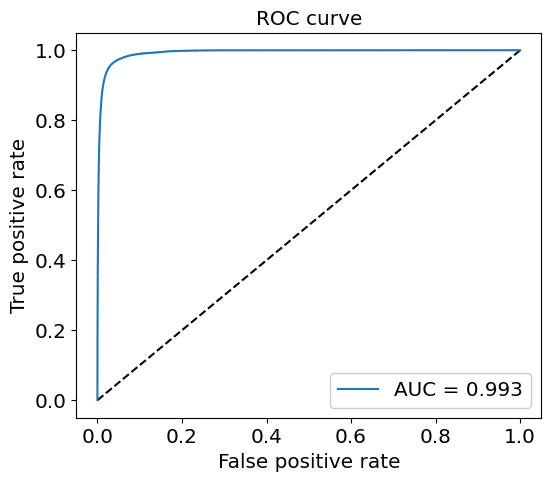

0.993231028270456

In [35]:
# Predict for test data
yTest_pred_prob = model.predict(xTest)
print(yTest_pred_prob.shape)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

peu.printClassificationMetrics(yTest, yTest_pred_prob)
peu.makeROCPlot(yTest, yTest_pred_prob, "Test Data", 2000, "", False)